In [12]:
%load_ext autoreload
%autoreload 2

from PyDeep import *
from sklearn.datasets import make_regression, make_blobs, make_moons
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
SEED = 12

# Multiple regression

In [113]:
N, D, K, b = 1000, 1, 2, 10

X, Y = make_regression(n_samples=N, n_features=D, n_targets=K, bias=b, noise=10, random_state=SEED)
if K == 1:  Y = Y[..., None]

# X, Y = make_moons(n_samples=N)
# Y = Y[..., None]

In [114]:
reg_model = Sequential(Linear(D, D*3),
                Linear(D*3, K))

criterion = MSE()

optim = SGD(reg_model, 1e-3)

routine = Trainer(X=X, Y=Y, model=reg_model, criterion=criterion, optim=optim, batch_size=32, epochs=1000, train_size=0.5, pace_eval_test=2, seed=SEED)

init_pred = reg_model(np.arange(np.min(X), np.max(X) + 1)[:, None])

TRAINING: 100%|██████████| 1000/1000 [00:04<00:00, 200.75it/s]


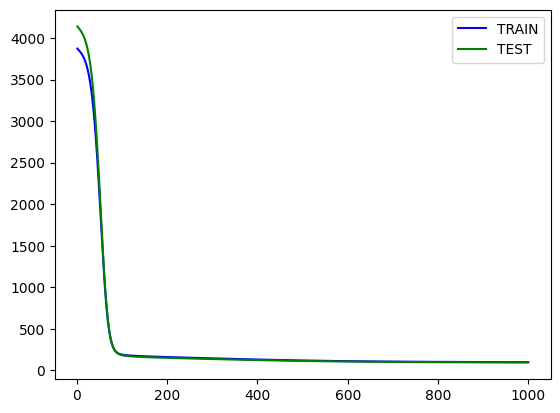

In [115]:
utils.plot(
    (*(rez := routine.training())[:2], "TRAIN"),
    (*rez[2:], "TEST")
)

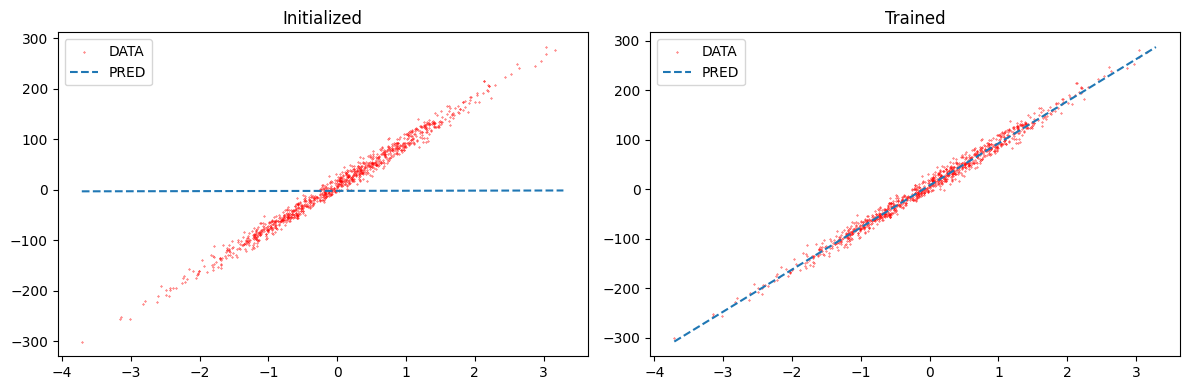

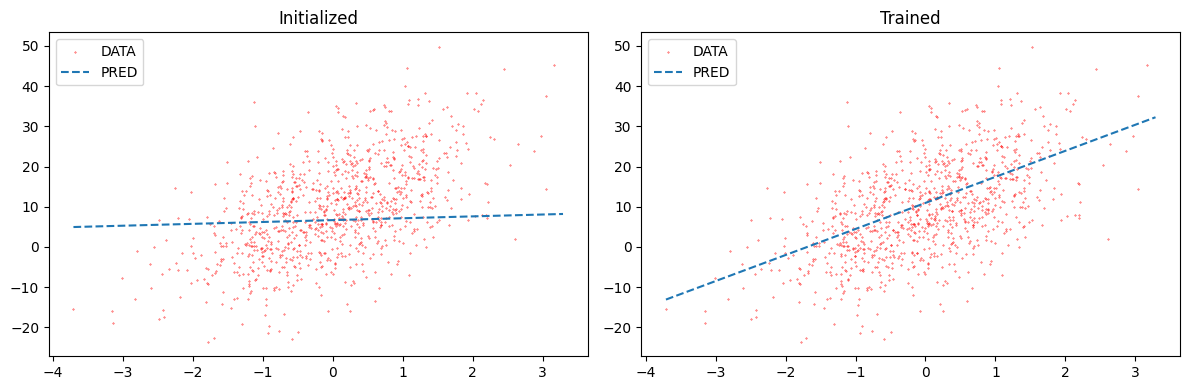

In [116]:
x_range = np.arange(np.min(X), np.max(X) + 1)[:, None]

for i in range(K):

    fig, axes = plt.subplots(1, 2, figsize=(12, 4))

    axes[0].scatter(X[:, 0], Y[:, i], s=0.1, label="DATA", c="red")
    axes[0].plot(x_range[:, 0], init_pred[:, i], linestyle="--", label="PRED")
    axes[0].set_title("Initialized")
    axes[0].legend()

    axes[1].scatter(X[:, 0], Y[:, i], s=0.1, label="DATA", c="red")
    axes[1].plot(x_range[:, 0], reg_model(x_range, track=False)[:, i], linestyle="--", label="PRED")
    axes[1].set_title("Trained")
    axes[1].legend()

    plt.tight_layout()
    plt.show()
    plt.close()

# Binary classification

In [4]:
N, D, K = 1000, 2, 2

X, Y = make_moons(n_samples=N, random_state=SEED)
Y = Y[..., None]

In [5]:
bclf_model = Sequential(
                Linear(D, D*3),
                Tanh(D*3),       
                Linear(D*3, K),
                Tanh(K),
                Linear(K, K-1),
                Sigmoid(K-1))

criterion = BCE()

optim = SGD(bclf_model, 1e-2)

routine = Trainer(X=X, Y=Y, model=bclf_model, criterion=criterion, optim=optim, batch_size=32, epochs=2000, train_size=0.99, pace_eval_test=2, seed=SEED)

In [6]:
init = utils.decision_boundary(X, lambda x: np.where(bclf_model(x) >= 0.5, 1, 0))

TRAINING: 100%|██████████| 2000/2000 [00:46<00:00, 43.29it/s]


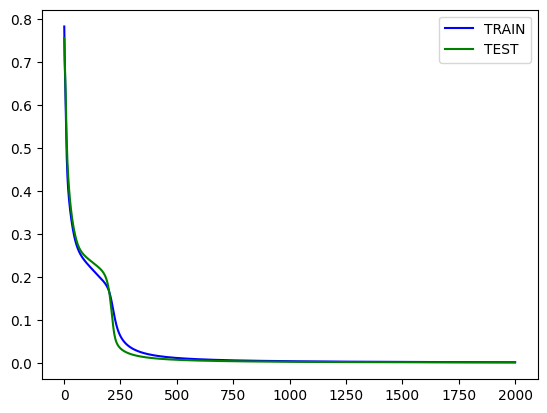

In [7]:
utils.plot(
    (*(rez := routine.training())[:2], "TRAIN"),
    (*rez[2:], "TEST")
)

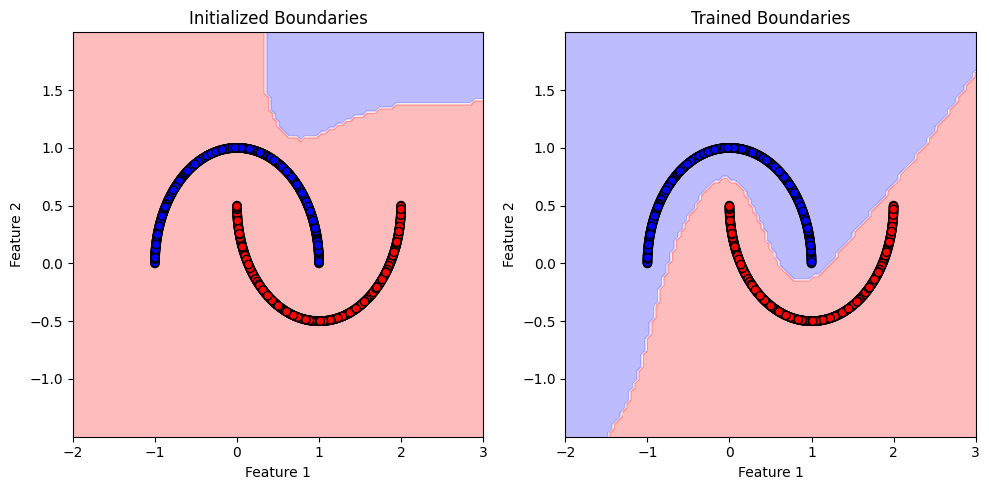

In [8]:
utils.boundary_comparison(X, Y, lambda x: np.where(bclf_model(x) >= 0.5, 1, 0), init)

# Multi classification

In [98]:
N, D, K = 1000, 2, 10

X, Y = make_blobs(n_samples=N, n_features=D, cluster_std=0.3, random_state=SEED)
Y_oh = np.eye(K)[Y]
Y = Y[..., None]

In [99]:
mclf_model = Sequential(
    Linear(D, D),
    Tanh(D),
    Linear(D, K),
    Softmax(K)
)

criterion = BCE()

optim = SGD(mclf_model, 1e-2)

routine = Trainer(X=X, Y=Y_oh, model=mclf_model, criterion=criterion, optim=optim, batch_size=32, epochs=2000, train_size=0.99, pace_eval_test=2, seed=SEED)

In [103]:
init = utils.decision_boundary(X, lambda x: np.argmax(mclf_model(x, track=False), axis=1))

TRAINING:   0%|          | 0/2000 [00:00<?, ?it/s]

TRAINING: 100%|██████████| 2000/2000 [00:30<00:00, 66.01it/s]


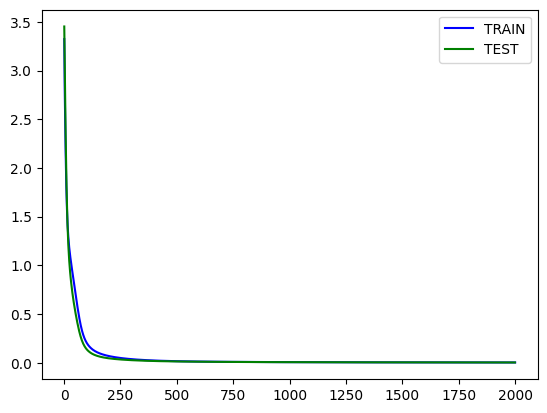

In [104]:
utils.plot(
    (*(rez := routine.training())[:2], "TRAIN"),
    (*rez[2:], "TEST")
)

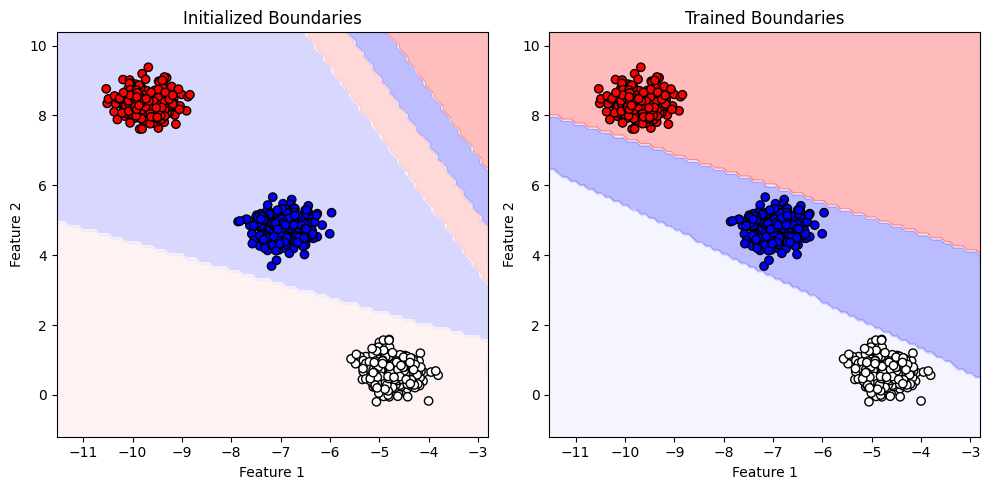

In [105]:
utils.boundary_comparison(X, Y, lambda x: np.argmax(mclf_model(x, track=False), axis=1), init)